In [3]:
!pip install pyathena

  Using cached pyathena-3.6.0-py3-none-any.whl.metadata (6.2 kB)
  Using cached urllib3-1.26.18-py2.py3-none-any.whl.metadata (48 kB)
Using cached pyathena-3.6.0-py3-none-any.whl (69 kB)
Using cached urllib3-1.26.18-py2.py3-none-any.whl (143 kB)
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.1.0
    Uninstalling urllib3-2.1.0:
      Successfully uninstalled urllib3-2.1.0

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [51]:
#pip install --upgrade pip

In [2]:
import os
import boto3
import sagemaker
import pandas as pd
import numpy as np
import csv, json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display, Image as IImage
from io import StringIO
from pyathena import connect
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [3]:
# Initialize Boto3 Rekognition client

rekognition_client = boto3.client("rekognition")
s3 = boto3.client("s3")

# Detect labels in Traffic sign images

In [4]:
# Define s3 bucket name, prefix and output csv file path

bucket_name = 'finalprojectdata'
prefix_key = 'traffic_signs/'
output_csv_key = 'csv_files/traffic_signs.csv'

In [5]:
# Function to detect text from an image 

def detect_text_from_image(bucket_name, image_key):
    if image_key.endswith('.jpg'):
        rekognition_response = rekognition_client.detect_text(Image={'S3Object': {'Bucket': bucket_name, 'Name': image_key}})
        return rekognition_response

In [6]:
# Get a list of objects in the s3 bucket

# all_results = []

# paginator = s3.get_paginator('list_objects_v2')
# result = paginator.paginate(Bucket=bucket_name, Prefix=prefix_key)

# for page in result:
#     if "Contents" in page:
#         for key in page[ "Contents" ]:
#             keyString = key[ "Key" ]
#             print(keyString)
#             if keyString.endswith('.jpg'):
#                 response = detect_text_from_image(bucket_name, keyString)
#                 all_results.append({'Image': keyString, 'TextDetections': response['TextDetections']})

In [7]:
# # Write aggregated results to a single CSV file

# csv_buffer = StringIO()
# writer = csv.DictWriter(csv_buffer, fieldnames=['Image', 'DetectedText', 'Type', 'Confidence'])
# writer.writeheader()
# for result in all_results:
#     image_key = result['Image']
#     for detection in result['TextDetections']:
#         detected_text = detection['DetectedText']
#         text_type = detection['Type']
#         confidence = detection['Confidence']
#         writer.writerow({'Image': image_key, 'DetectedText': detected_text, 'Type': text_type, 'Confidence': confidence})
        
# # Upload CSV string to S3

# csv_buffer.seek(0)
# s3.put_object(Body=csv_buffer.getvalue(), Bucket=bucket_name, Key=output_csv_key)

# print(f"Text detection results saved to: s3://{bucket_name}/{output_csv_key}")

In [8]:
# Create athena database

sess = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sess.default_bucket()
region = boto3.Session().region_name

sagemaker_client = boto3.client(service_name="sagemaker", region_name=region)

ingest_create_athena_db_passed = False

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [9]:
# Set Athena database name

database_name = "velocityvision"

In [10]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries

s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [11]:
# Connect to s3 using PyAthena

conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [12]:
# SQL statement to execute

statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS velocityvision


""


In [13]:
input_data_location = "s3://finalprojectdata/csv_files/traffic_signs"

In [14]:
# SQL statement to execute the traffic signs text detection

table_name1 = 'traffic_signs'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name1}', conn)

create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name1}(
            image_id string,
            detected_text string,
            type string,
            confidence float
            )
            
            ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
            LOCATION '{input_data_location}'
            TBLPROPERTIES ('skip.header.line.count'='1')
"""

pd.read_sql(create_table, conn)

pd.read_sql(f'SELECT * FROM {database_name}.{table_name1} LIMIT 5', conn)

,image_id,detected_text,type,confidence
0,traffic_signs/000000_jpg.rf.b11f308f16626f9f79...,30,LINE,99.548250
1,traffic_signs/000000_jpg.rf.b11f308f16626f9f79...,RYARSH,LINE,99.415030
2,traffic_signs/000000_jpg.rf.b11f308f16626f9f79...,Please reduce,LINE,99.164894
3,traffic_signs/000000_jpg.rf.b11f308f16626f9f79...,your speed,LINE,99.207320
4,traffic_signs/000000_jpg.rf.b11f308f16626f9f79...,30,WORD,99.548250


In [15]:
# SQL statement to filter rows for "WORD" type

query1 = "SELECT * FROM {}.{} WHERE type='WORD'".format(database_name, table_name1)
traffic_signs_df = pd.read_sql(query1, conn)

In [16]:
traffic_signs_df.shape

(7984, 4)

# Exploratory Data Analysis

## Checking duplicate values

In [17]:
traffic_signs_df.duplicated().sum()

9

In [18]:
# Removing duplicate rows

traffic_signs_df.drop_duplicates(inplace = True)
traffic_signs_df.shape

(7975, 4)

In [19]:
traffic_df = traffic_signs_df.groupby(['image_id', 'type']).agg({'detected_text': ' '.join, 'confidence':'max'}).reset_index()
traffic_df.head()

,image_id,type,detected_text,confidence
0,traffic_signs/000000_jpg.rf.b11f308f16626f9f79...,WORD,30 RYARSH Please reduce your speed,99.548250
1,traffic_signs/000005_jpg.rf.d730849ae93a7c211a...,WORD,T lamy STEEP - a T 30 alamy a alamy 20 is plen...,99.875980
2,traffic_signs/000007_jpg.rf.226fe0751cf8ba445b...,WORD,30,99.148350
3,traffic_signs/000008_jpg.rf.bd6ae6db0f8c0eb727...,WORD,30 stock.photo www.alamy.com-DB9EAN,97.540085
4,traffic_signs/000009_jpg.rf.df4118d1d26fa7a259...,WORD,3010 www.alamy.com - EKPJRP,87.884930


## Analysis of Vehicle Speed 

In [20]:
# SQL statement to execute the analysis of vehicle speed

table_name2 = 'vehicle_speed'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name2}', conn)

create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name2}(
             latitude float,
             longitude float,
             target_speed float,
             way_maxspeed float,
             speed_osrm float,
             elevation float,
             fwd_azimuth float,
             way_type string,
             way_surface string,
             node_intersection string,
             node_railway string,
             node_crossing string,
             node_highway string,
             node_stop string,
             start_stop int,
             azimuth_diff int,
             elevation_diff float
             )
             
             ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
             LOCATION 's3://finalprojectdata/vehicle_speed'
             TBLPROPERTIES ('skip.header.line.count'='1')
"""

pd.read_sql(create_table, conn)

""


In [21]:
vehicle_speed_df = pd.read_sql(f'SELECT * FROM {database_name}.{table_name2}', conn)
vehicle_speed_df.head()

,latitude,longitude,target_speed,way_maxspeed,speed_osrm,elevation,fwd_azimuth,way_type,way_surface,node_intersection,node_railway,node_crossing,node_highway,node_stop,start_stop,azimuth_diff,elevation_diff
0,50.397060,14.913273,39.739456,130.0,28.837246,229.77516,46.24135,motorway,asphalt,,,,,,0,0.0,-0.025587
1,50.397068,14.913283,39.717785,130.0,28.875628,229.74959,46.24135,motorway,asphalt,,,,,,0,0.0,-0.025587
2,50.397076,14.913294,39.696114,130.0,28.914007,229.72400,46.24135,motorway,asphalt,,,,,,0,0.0,-0.025587
3,50.397080,14.913303,39.674442,130.0,28.952387,229.69841,46.24135,motorway,asphalt,,,,,,0,0.0,-0.025587
4,50.397087,14.913314,39.652770,130.0,28.990767,229.67282,46.24135,motorway,asphalt,,,,,,0,0.0,-0.025587


# Exploratory Data Analysis

In [22]:
vehicle_speed_df.shape

(12165, 17)

In [23]:
# Display basic information about the DataFrame

vehicle_speed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12165 entries, 0 to 12164
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   latitude           12165 non-null  float64
 1   longitude          12165 non-null  float64
 2   target_speed       12165 non-null  float64
 3   way_maxspeed       12165 non-null  float64
 4   speed_osrm         12165 non-null  float64
 5   elevation          12165 non-null  float64
 6   fwd_azimuth        12165 non-null  float64
 7   way_type           12165 non-null  object 
 8   way_surface        12165 non-null  object 
 9   node_intersection  12165 non-null  object 
 10  node_railway       12165 non-null  object 
 11  node_crossing      12165 non-null  object 
 12  node_highway       12165 non-null  object 
 13  node_stop          12165 non-null  object 
 14  start_stop         12165 non-null  int64  
 15  azimuth_diff       12158 non-null  float64
 16  elevation_diff     121

In [24]:
# Display Summary Statistics

vehicle_speed_df.describe()

,latitude,longitude,target_speed,way_maxspeed,speed_osrm,elevation,fwd_azimuth,start_stop,azimuth_diff,elevation_diff
count,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12165.000000,12158.000000,12165.000000
mean,50.513208,15.013062,29.237012,109.865187,24.395164,273.754074,14.171596,0.000082,0.134644,-0.000678
std,0.101574,0.101284,10.099827,31.682745,7.511936,57.307514,63.838281,0.009067,2.685429,0.127193
min,50.397060,14.900258,0.205150,30.000000,2.608163,206.000000,-178.271000,0.000000,0.000000,-2.384993
25%,50.413380,14.926530,19.847204,90.000000,20.165674,219.000000,-12.500012,0.000000,0.000000,-0.025634
50%,50.494392,14.973766,33.936966,130.000000,28.471680,250.368090,14.062474,0.000000,0.000000,0.000000
75%,50.639430,15.097621,37.584003,130.000000,29.292814,337.000000,55.357777,0.000000,0.000000,0.025364
max,50.664910,15.228758,39.742664,130.000000,50.000000,384.000000,180.000000,1.000000,179.000000,1.883534


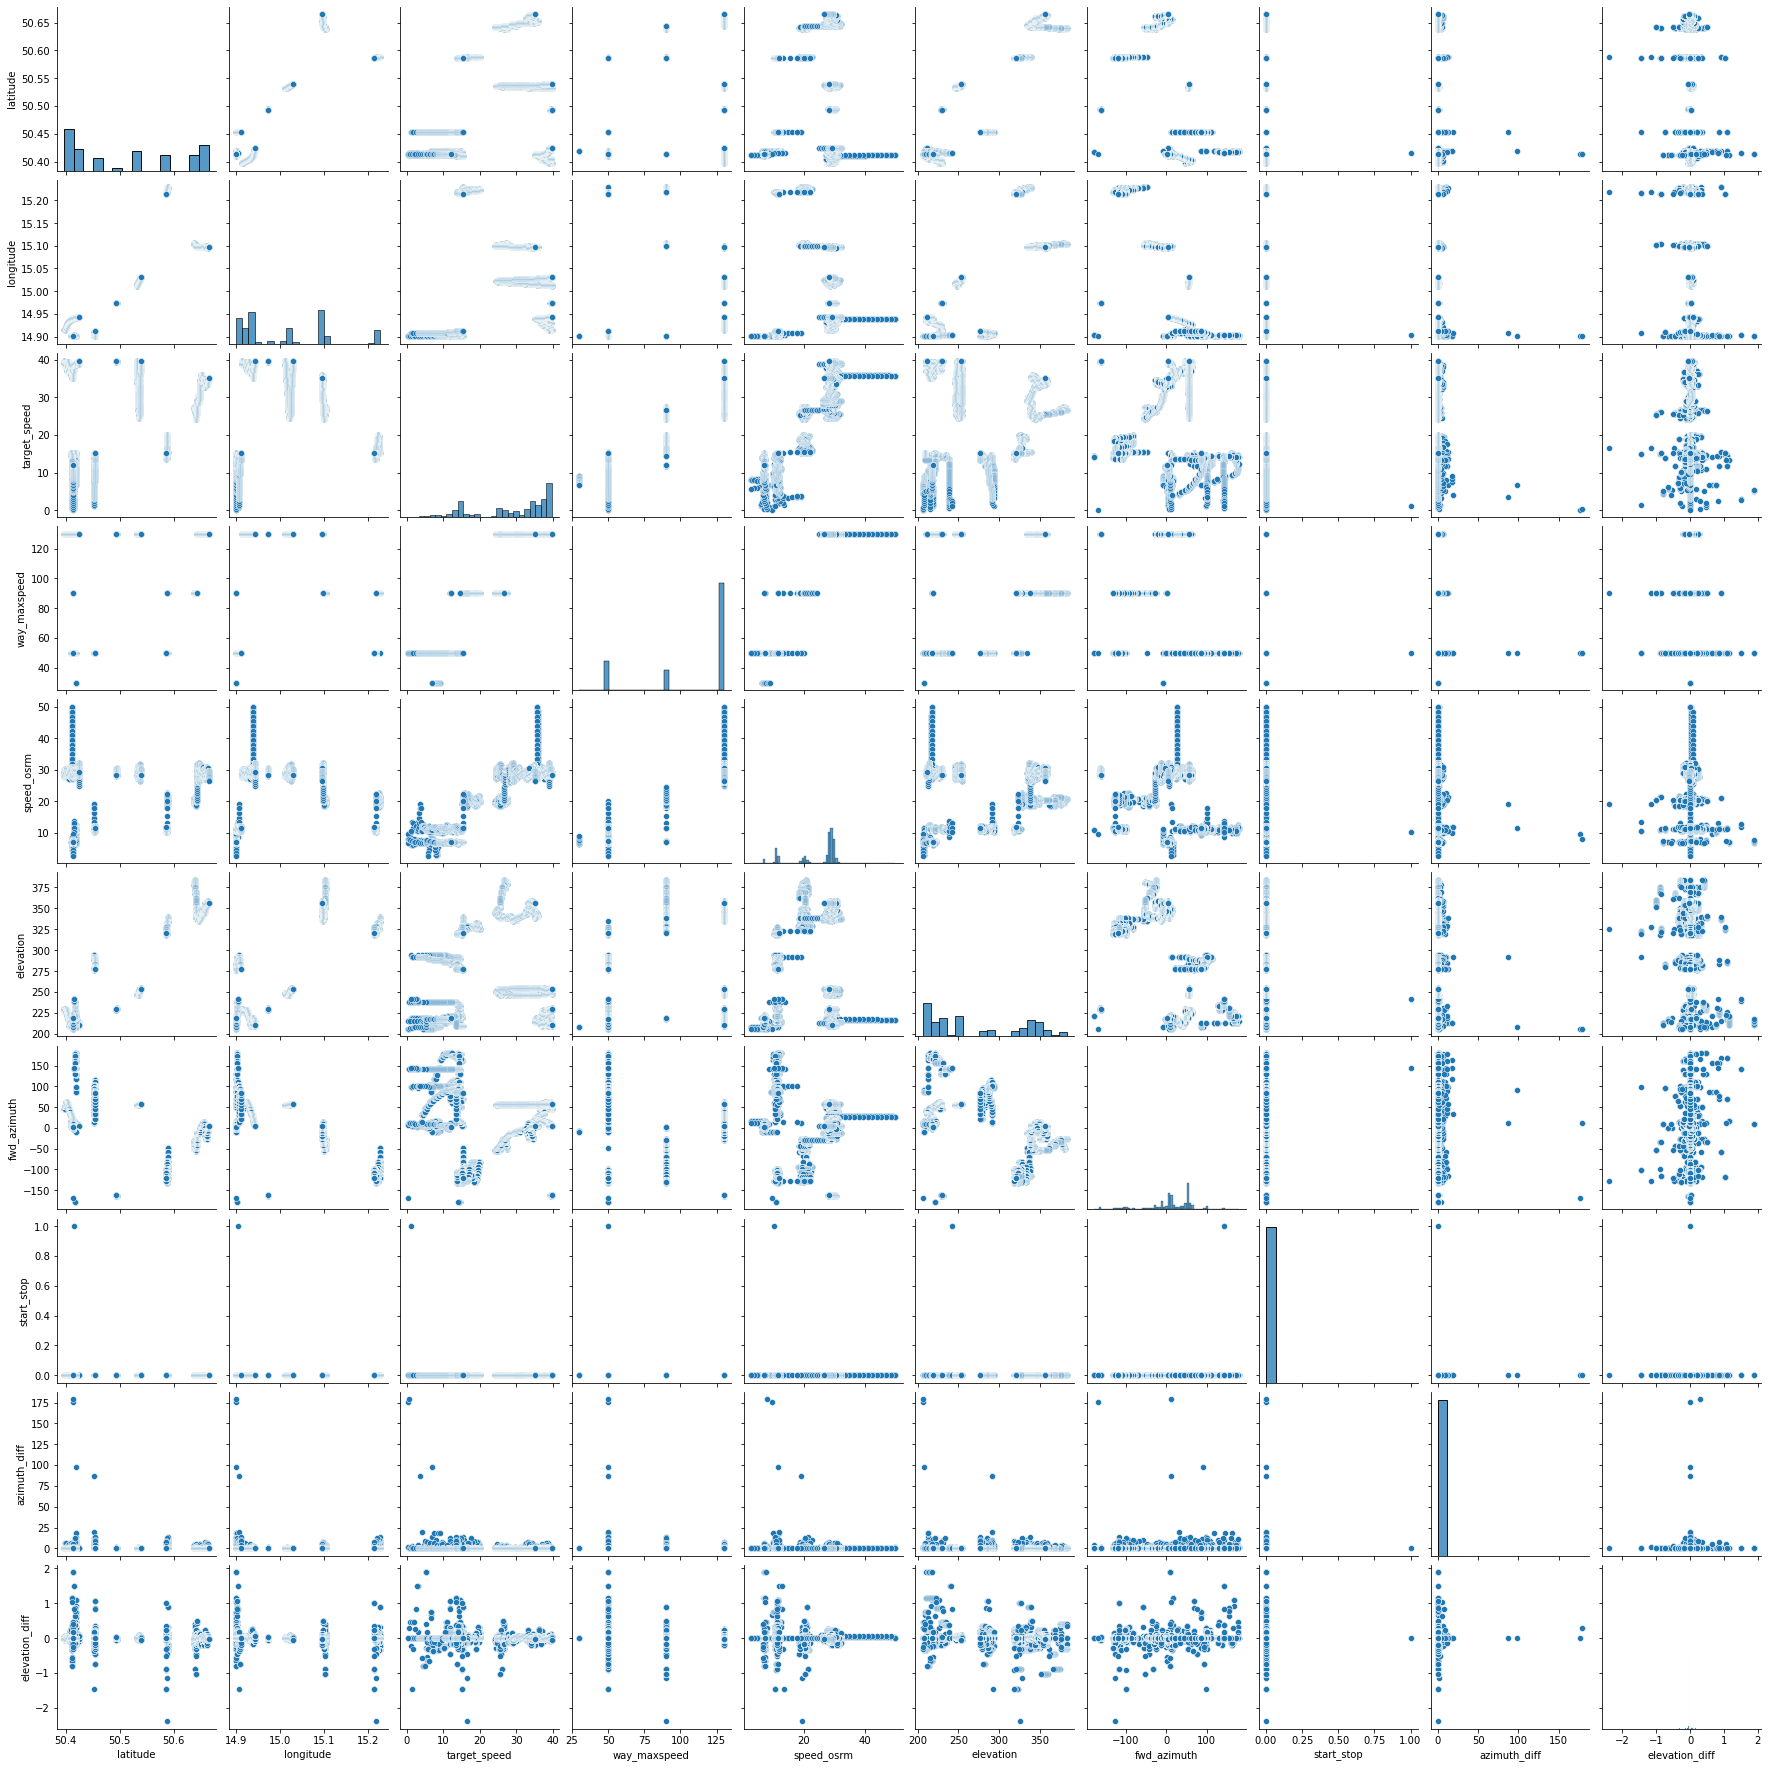

In [25]:
# Visualize Distributions of numerical variables

sns.pairplot(vehicle_speed_df)

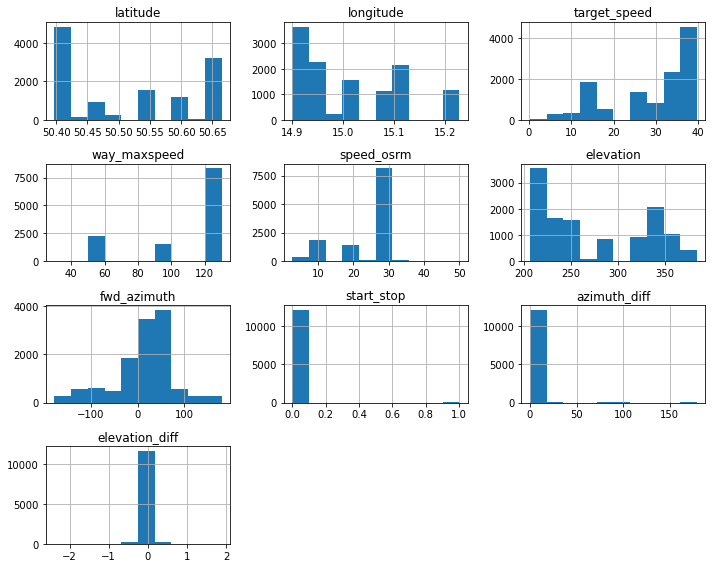

In [26]:
# Visualize histograms of numerical variables

vehicle_speed_df.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

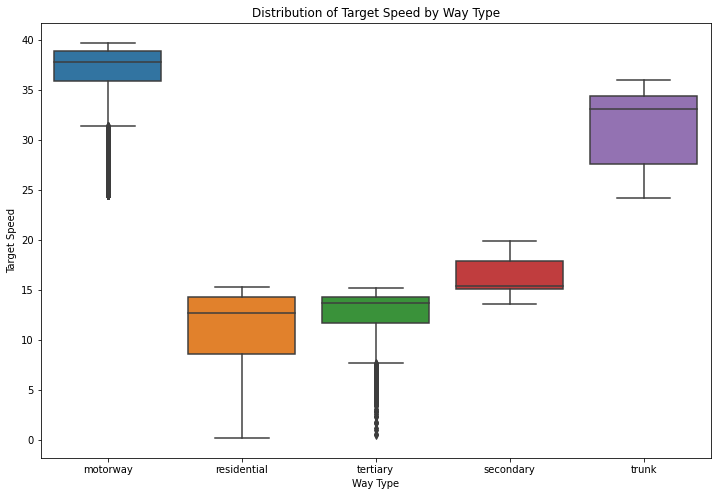

In [27]:
# Visualize box plots of numerical variables grouped by categorical variables

plt.figure(figsize=(12, 8))
sns.boxplot(x='way_type', y='target_speed', data=vehicle_speed_df)
plt.xlabel('Way Type')
plt.ylabel('Target Speed')
plt.title('Distribution of Target Speed by Way Type')
plt.show()

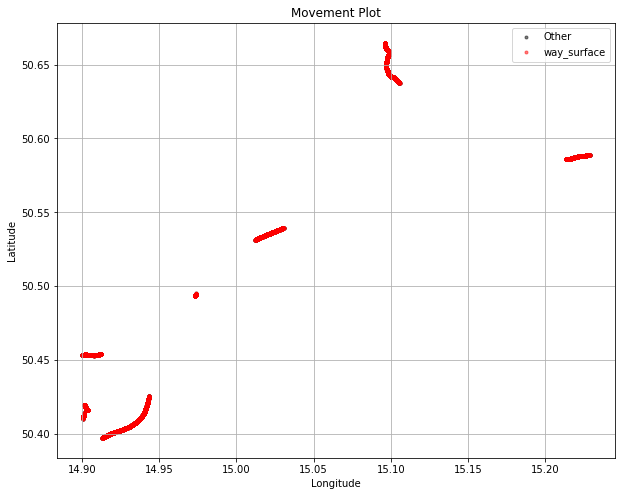

In [28]:
# Define colors for different columns
color_map = {
    'way_surface': 'red',
    'node:intersection': 'blue',
    'node:railway': 'green',
    'node:crossing': 'orange',
    'node:highway': 'purple'
}

# Plot movement using latitude and longitude
plt.figure(figsize=(10, 8))

# Scatter plot for latitude & longitude
plt.scatter(vehicle_speed_df['longitude'], vehicle_speed_df['latitude'], alpha=0.5, marker='.', color='black', label='Other')

# Scatter plot for desired columns
for column, color in color_map.items():
    if column in vehicle_speed_df.columns:
        plt.scatter(vehicle_speed_df[vehicle_speed_df[column].notnull()]['longitude'], 
                    vehicle_speed_df[vehicle_speed_df[column].notnull()]['latitude'], 
                    alpha=0.5, marker='.', color=color, label=column)

# Add labels & title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Movement Plot')

# Show legend
plt.legend()

plt.grid(True)
plt.show()

Text(0, 0.5, 'Count')

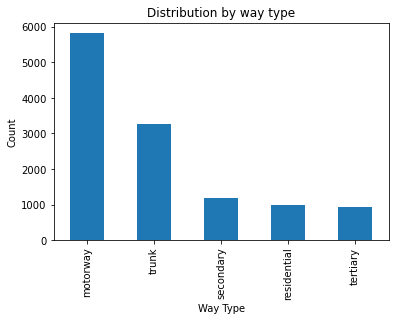

In [29]:
# Distrubition by Way type

vehicle_speed_df['way_type'].value_counts().plot(kind="bar", title="Distribution by way type")
plt.xlabel("Way Type")
plt.ylabel("Count")

# Correlation

Lets study the correlation between different attributes in the dataset

<AxesSubplot:>

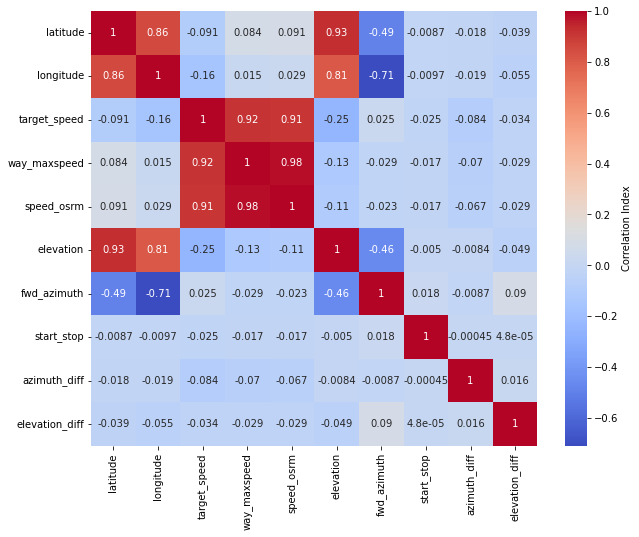

In [30]:
corr = vehicle_speed_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap = 'coolwarm', cbar_kws={'label': 'Correlation Index'})

From the above correlation Heatmap, it is observed that the below predictors are highly correlated.
(1) latitude and elevation
(2) target_speed and way_maxspeed
(3) way_maxspeed and speed_osrm
(4) target_speed and elevation

# 2. Data Preprocessing

## 2.1. Handling Missing Values

In [31]:
vehicle_speed_df.isnull().sum()

latitude             0
longitude            0
target_speed         0
way_maxspeed         0
speed_osrm           0
elevation            0
fwd_azimuth          0
way_type             0
way_surface          0
node_intersection    0
node_railway         0
node_crossing        0
node_highway         0
node_stop            0
start_stop           0
azimuth_diff         7
elevation_diff       0
dtype: int64

In [32]:
# Dropping columns that have null values

vehicle_speed_df = vehicle_speed_df.drop(['node_intersection', 'node_railway', 'node_crossing', 'node_highway', 'node_stop'], axis=1)

# Dropping rows that have null values

vehicle_speed_df = vehicle_speed_df.dropna(subset=['azimuth_diff'])

# Multicollinearity

Lets address the multicollinearity issue by calculating Variance Inflation Factor (VIF) and removing highly correlated predictors.

In [33]:
# Separate the predictors and target variables

X_pred = vehicle_speed_df.drop(['target_speed'], axis=1)
y_target = vehicle_speed_df['target_speed']

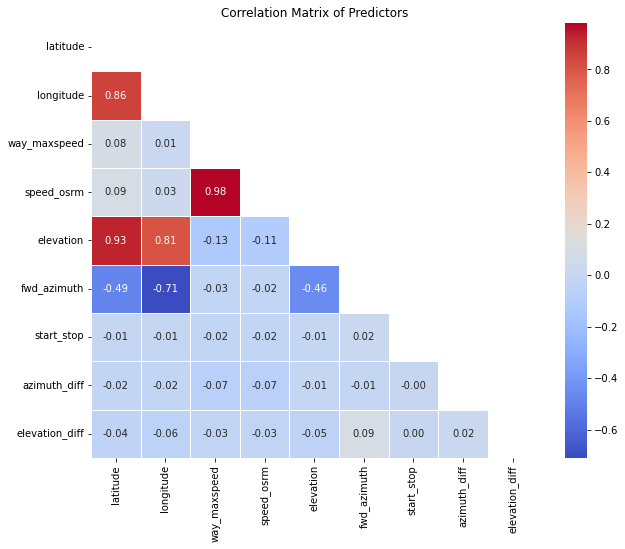

In [34]:
# Calculate correlation matrix for predictors
correlation_matrix = X_pred.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Predictors')
plt.show()

To address the issue of multicollinearity, it is suggested to remove the columns longitude, way_maxspeed, and elevation. However, since determining the target speed of a vehicle relies on multiple factors, including spatial information about the vehicle's location, both latitude and longitude should be taken into account.

# Feature transformation

The maximum allowed speed is measured in km/hr whereas target_speed and speed_osrm are measured in m/s. Hence transforming the target_speed and speed_osrm values to km/hr

In [35]:
# Convert m/s to km/hr for the target_speed and speed_osrm column

vehicle_speed_df['target_speed'] = vehicle_speed_df['target_speed'] * 3.6

vehicle_speed_df['speed_osrm'] = vehicle_speed_df['speed_osrm'] * 3.6

# Feature Creation

Lets create a new feature speed_deviation that computes the difference between target_speed and way_maxspeed to see if the vehicle is driving above or below the allowed speed limit.

In [36]:
vehicle_speed_df['speed_deviation'] = vehicle_speed_df['target_speed'] - vehicle_speed_df['way_maxspeed']

# Drop Irrelevant fields

In [37]:
# Dropping fields that exhibit multicollinearity 

vehicle_speed_df = vehicle_speed_df.drop(['way_maxspeed', 'elevation'], axis=1)

# Dropping irrelevant columns

vehicle_speed_df = vehicle_speed_df.drop(['fwd_azimuth', 'way_surface', 'start_stop', 'azimuth_diff', 'elevation_diff'], axis=1)

# Feature Selection

Based on the insights from the correlation matrix heatmap and other transformation techniques, the useful predictors for the final model include: latitude, longitude, speed_osrm, way_type, speed_deviation and target_speed.

In [38]:
final_df = vehicle_speed_df.copy()

# Encoding Categorical Variables

In [39]:
# Convert categorical variables to dummy variables

final_df = pd.get_dummies(final_df, columns= ['way_type'], drop_first=True)
final_df.head()

,latitude,longitude,target_speed,speed_osrm,speed_deviation,way_type_residential,way_type_secondary,way_type_tertiary,way_type_trunk
0,50.397060,14.913273,143.062042,103.814086,13.062042,0,0,0,0
1,50.397068,14.913283,142.984026,103.952261,12.984026,0,0,0,0
2,50.397076,14.913294,142.906010,104.090425,12.906010,0,0,0,0
3,50.397080,14.913303,142.827991,104.228593,12.827991,0,0,0,0
4,50.397087,14.913314,142.749972,104.366761,12.749972,0,0,0,0


## Transfer the Final Dataframe to s3 bucket

In [40]:
import io

s3_client = boto3.client("s3")
bucket_name = 'vvspeedproject'
input_key = 'data_files/final_df/final_df.csv'

with io.StringIO() as csv_buffer:
    final_df.to_csv(csv_buffer, index=False, header=True)
    response = s3_client.put_object(Bucket=bucket_name, Key=input_key, Body=csv_buffer.getvalue())

# Data Partitioning

## Separate predictor and target variables

In [41]:
# Separate X and y variables

X = final_df.drop(['target_speed'], axis=1)
y = final_df['target_speed']
predictors = X.columns
outcome = 'target_speed'

## Split dataset into training, test and validation sets

In [42]:
# Split the training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

# Split the test and validation set
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [43]:
# Proportions of training, test and validation data

train_prop = len(X_train)/len(final_df)
test_prop = len(X_test)/len(final_df)
valid_prop = len(X_valid)/len(final_df)

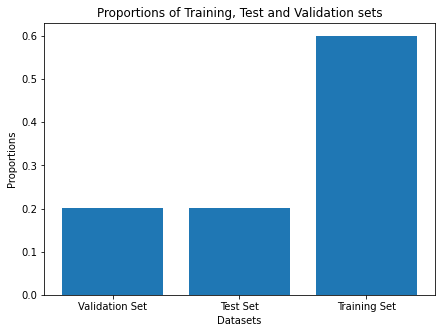

In [44]:
plt.figure(figsize=(7,5))
labels = ['Validation Set', 'Test Set', 'Training Set']
proportions = [valid_prop, test_prop, train_prop]
plt.bar(labels,proportions)
plt.xlabel("Datasets")
plt.ylabel("Proportions")
plt.title("Proportions of Training, Test and Validation sets")
plt.show()

## Standardize numerical variables

In [45]:
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler()
X_train = scale.fit_transform(X_train)
X_valid = scale.fit_transform(X_valid)
X_test = scale.fit_transform(X_test)

X_train = pd.DataFrame(X_train, columns=predictors)
X_valid = pd.DataFrame(X_valid, columns=predictors)
X_test = pd.DataFrame(X_test, columns=predictors)

## Transfer the training data to the s3 bucket

In [46]:
train_data, test_data = np.split(final_df.sample(frac=1, random_state=777), 
                                 [int(0.7 * len(final_df))])

print(train_data.shape, test_data.shape)

(8510, 9) (3648, 9)


In [47]:
# Initialize s3 boto client
s3_client = boto3.client("s3")

# Define bucket name
bucket_name = 'vvspeedproject'

# Define s3 key
train_path = 'data_files/train_data/train.csv'

response = s3_client.get_object(Bucket = bucket_name, Key = train_path)

with io.StringIO() as csv_buffer:
    train_data.to_csv(csv_buffer, index=False, header=False)
    
    response = s3_client.put_object(
        Bucket = bucket_name, Key = train_path, Body=csv_buffer.getvalue()
    )

In [48]:
# training data
s3_train_data = sagemaker.inputs.TrainingInput(s3_data=\
                                               's3://{}/data_files/train_data'.format(bucket_name), content_type='csv')

# Model Training

## Train the model using Sagemaker built-in XGBoost Algorithm

In [49]:
from sagemaker.xgboost.estimator import image_uris

bucket_name = 'vvspeedproject'
prefix = 'xgboost-model'
output_path = 's3://{}/{}/{}/output'.format(bucket_name, prefix, 'xgb-built-in-algo')

# Looks for the XGBoost image URI and builds an XGBoost container
xgboost_container = sagemaker.image_uris.retrieve("xgboost", region, "latest")

# SageMaker estimator that calls the xgboost-container
xgb_model = sagemaker.estimator.Estimator(image_uri=xgboost_container,
                                          role=sagemaker.get_execution_role(),
                                          instance_count=1,
                                          instance_type='ml.m5.large',
                                          output_path=output_path)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [50]:
# Setting the hyperparameters

xgb_model.set_hyperparameters(max_depth=5, eta=0.2, gamma=4, min_child_weight=6,
                        subsample=0.7, objective='reg:linear', num_round=100)

In [51]:
# Train the model

xgb_model.fit({'train': s3_train_data})

INFO:sagemaker:Creating training-job with name: xgboost-2024-04-14-11-31-12-541


2024-04-14 11:31:12 Starting - Starting the training job...
2024-04-14 11:31:28 Starting - Preparing the instances for training...
2024-04-14 11:32:01 Downloading - Downloading input data......
2024-04-14 11:32:46 Downloading - Downloading the training image...
2024-04-14 11:33:37 Training - Training image download completed. Training in progress.
2024-04-14 11:33:37 Uploading - Uploading generated training modelArguments: train
[2024-04-14:11:33:30:INFO] Running standalone xgboost training.
[2024-04-14:11:33:30:INFO] Path /opt/ml/input/data/validation does not exist!
[2024-04-14:11:33:30:INFO] File size need to be processed in the node: 0.58mb. Available memory size in the node: 272.5mb
[2024-04-14:11:33:30:INFO] Determined delimiter of CSV input is ','
[11:33:30] S3DistributionType set as FullyReplicated
[11:33:30] 8510x8 matrix with 68080 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[11:33:30] src/tree/updater_prune.cc:74: tree pruning end, 1 ro

## Deploy the XGBoost model

In [52]:
xgb_predictor = xgb_model.deploy(initial_instance_count=1, instance_type="ml.m5.large")

INFO:sagemaker:Creating model with name: xgboost-2024-04-14-11-34-24-972
INFO:sagemaker:Creating endpoint-config with name xgboost-2024-04-14-11-34-24-972
INFO:sagemaker:Creating endpoint with name xgboost-2024-04-14-11-34-24-972


-----!

## Make predictions using trained model

In [53]:
from sagemaker.serializers import CSVSerializer

# load the data into an array
test_array = test_data.drop(['target_speed'], axis=1).values

# set the serializer type
xgb_predictor.serializer = CSVSerializer()

# Make predictions
y_preds = xgb_predictor.predict(test_array).decode('utf-8')

y_preds_arr = np.fromstring(y_preds[1:], sep=',')
print(y_preds_arr.shape)

(3648,)


## Model Evaluation

In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the actual target values from the test data
y_true = test_data['target_speed'].values

# Calculate evaluation metrics
mae = mean_absolute_error(y_true, y_preds_arr)
rmse = np.sqrt(mean_squared_error(y_true, y_preds_arr))

print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 57.32543507634656
Root Mean Squared Error: 65.74258253762859


## Cleanup

In [55]:
# clean-up by deleteting endpoint
xgb_predictor.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: xgboost-2024-04-14-11-34-24-972
INFO:sagemaker:Deleting endpoint with name: xgboost-2024-04-14-11-34-24-972
